# Sagan Workshop

In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('paper')

%matplotlib inline

def wrap(val):
    while val < 0:
        val += 2*np.pi
    while val > 2*np.pi:
        val -= 2*np.pi
    return val
npwrap = np.vectorize(wrap)

In [2]:
sim = rebound.Simulation()
sim.getWidget(size=(400,400))

Widget(count=2, height=400.0, orbits=True, orientation=(0.0, 0.0, 0.0, 1.0), overlay='REBOUND (ias15), N=0, t=…

In [3]:
sim.add(m=1)

In [4]:
sim.add(m=1.e-5, a=1., e=0.3)

In [5]:
sim.move_to_com()

In [6]:
sim.integrate(10000)

# Adding GR with REBOUNDx

In [7]:
import reboundx
rebx = reboundx.Extras(sim)
gr = rebx.add("gr")
gr.params["c"] = 100.

In [8]:
sim.integrate(30000)

# Protip: Use SimulationArchives!

Stores simulation with no information loss and makes your integrations reproducible by others. See examples in the REBOUND and REBOUNDx repos:

https://github.com/hannorein/rebound/blob/master/ipython_examples/SimulationArchive.ipynb
https://github.com/dtamayo/reboundx/blob/master/ipython_examples/SimulationArchive.ipynb

# Celmech

Tools for orbital dynamics.

How close to resonance do you have to be to be in resonance? Let's set it up REALLY close!

In [9]:
sim = rebound.Simulation()
sim.add(m=1)
sim.add(m=1.e-4, P=1.)
sim.add(m=1.e-4, P=1.5)
sim.move_to_com()
ps = sim.particles

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


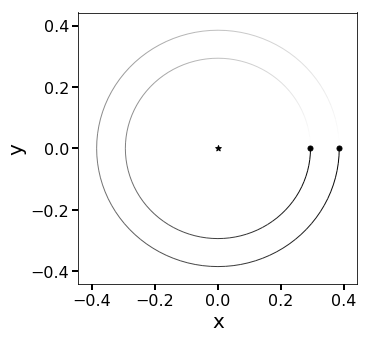

In [10]:
fig = rebound.OrbitPlot(sim)

# Resonant Angle Should Librate?

# $\phi = 3\lambda_2 - 2\lambda_1 - \varpi_1$

In [11]:
Nout = 1000
phi = np.zeros(Nout)
times = np.linspace(0, 300, Nout)

for i, time in enumerate(times):
    sim.integrate(time)
    phi[i] = 3*ps[2].l - 2*ps[1].l - ps[1].pomega

Even though we set up the system right at the resonant period ratio, the resonant angle circulates from 0 to 2pi. Why?

Text(0,0.5,'$\\phi$')

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


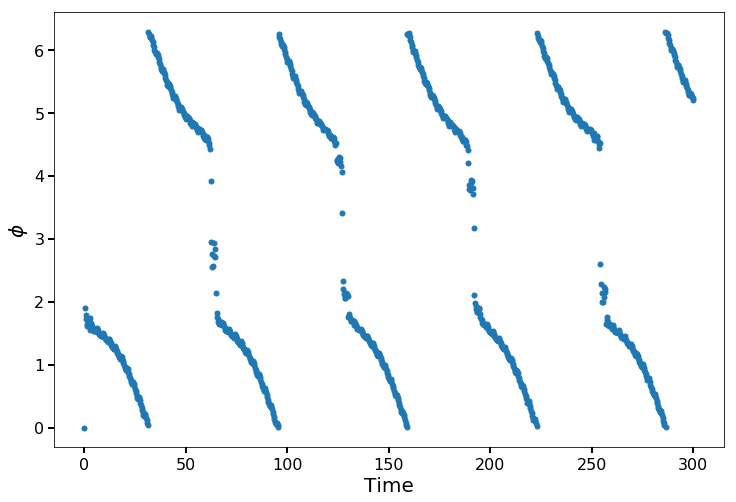

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, npwrap(phi), '.')
ax.set_xlabel('Time')
ax.set_ylabel(r'$\phi$')

Proximity to resonance depends on not only the period ratio but also the eccentricities, masses, pericenters etc. Let's visualize the phase space with celmech:

In [15]:
from celmech import Andoyer, AndoyerHamiltonian
%matplotlib notebook

class Clicker(object):
    def __init__(self,j,k, Zstar, projection=None):
        self.ax = plt.subplot('111', projection=projection)
        self.j = j
        self.k = k
        self.Zstar = Zstar
        self.projection = projection
        self.cid = self.ax.figure.canvas.mpl_connect('button_press_event', self)

    def __call__(self, event):
        phi = event.xdata
        Z = event.ydata
        if Z < 0:
            return
        andvars = Andoyer.from_Z(self.j,self.k,Z,phi,Zstar, m1=1.e-4, m2=1.e-4)
        self.andvars=andvars
        H = AndoyerHamiltonian(andvars)
        tmax=100*andvars.params['tau']
        Nout = 1000
        times = np.linspace(0, tmax, Nout)
        
        Z, phi = np.zeros(Nout), np.zeros(Nout)
        for i, time in enumerate(times):
            H.integrate(time)
            Z[i] = H.state.Z
            phi[i] = H.state.phi
        self.ax.plot(npwrap(phi), Z, 'r.')       

<IPython.core.display.Javascript object>


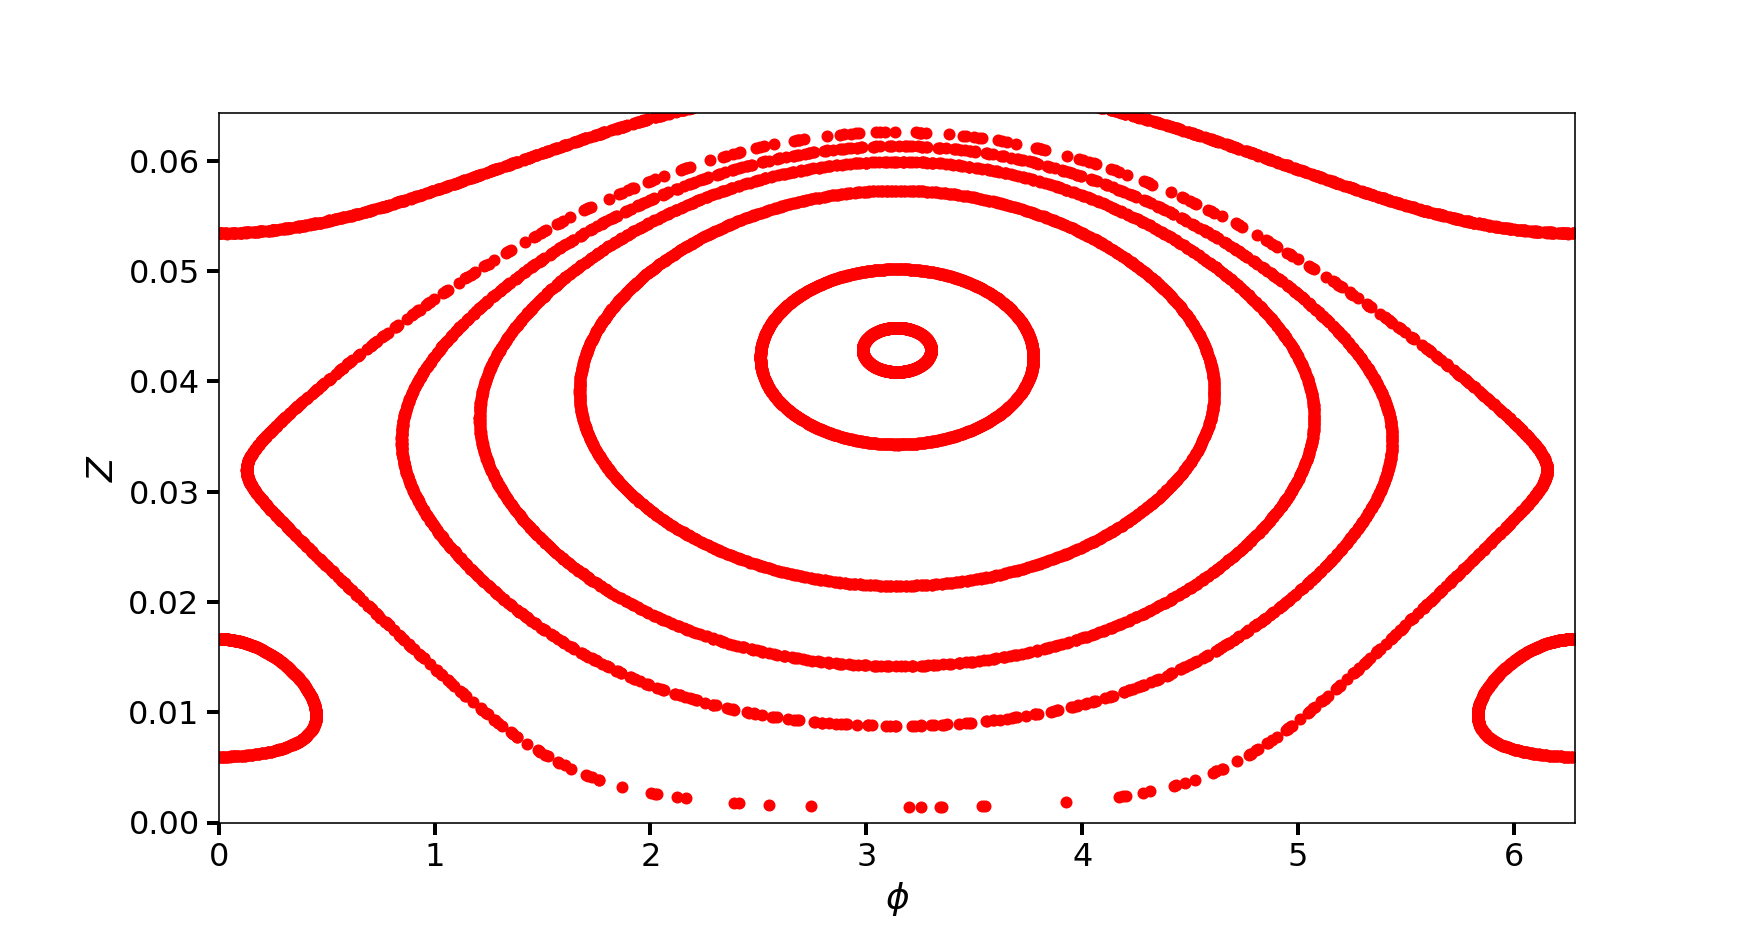

In [16]:
order=1
j=3
Zstar = 0.0429

clicker=Clicker(j,order,Zstar) 
clicker.ax.set_xlim(0,2*np.pi)
clicker.ax.set_ylim(0,1.5*Zstar)
clicker.ax.set_xlabel('$\phi$',fontsize=18)
clicker.ax.set_ylabel('$Z$',fontsize=18)
plt.show()

# New Discovery!

<IPython.core.display.Javascript object>


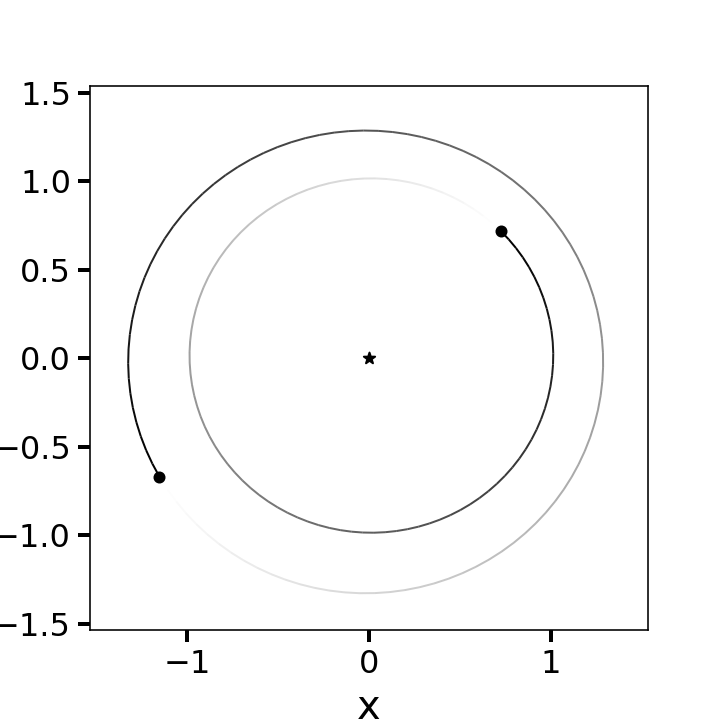

In [17]:
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1.e-4, P=6.2968, e=0.0199, pomega=-2.2911, f=3.0725)
sim.add(m=1.e-4, P=9.3964, e=0.0214, pomega=0.8490, f=-3.4642)
sim.move_to_com()
ps = sim.particles
fig = rebound.OrbitPlot(sim)

In [16]:
ps[2].P/ps[1].P

1.4922500317621668

Use Celmech to convert the snapshots of an Nbody integration into the resonant Z and phi variables

In [18]:
j = 3
order = 1

times = np.linspace(0,2000,Nout)
Z,phi=np.zeros((2,Nout))
for i,t in enumerate(times):
    avars = Andoyer.from_Simulation(sim,j,order)
    Z[i] = avars.Z
    phi[i] = avars.phi
    sim.integrate(t)

Here the resonant angle does librate!

<IPython.core.display.Javascript object>


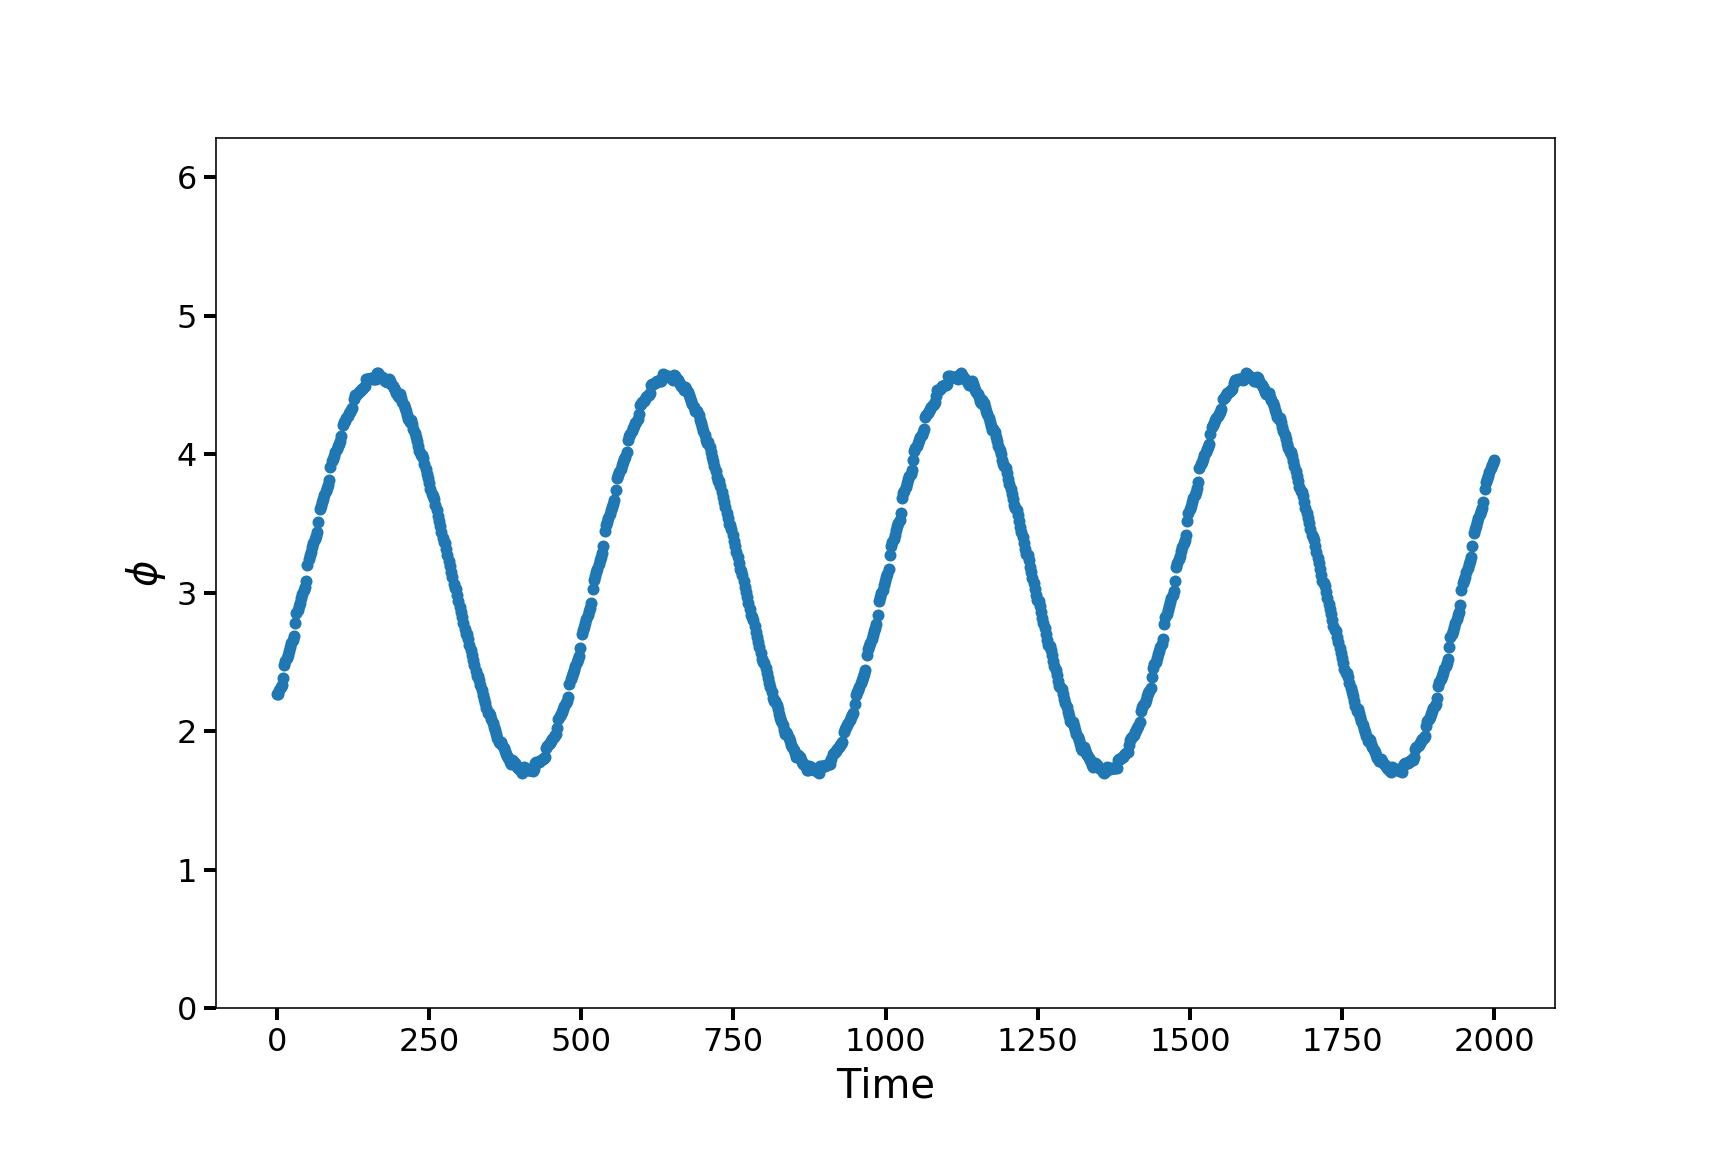

(0, 6.283185307179586)

In [19]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, npwrap(phi), '.')
ax.set_xlabel('Time')
ax.set_ylabel(r'$\phi$')
ax.set_ylim([0, 2*np.pi])

In [20]:
avars.Zstar

0.042906745966533905